In [10]:
from spline import spline
import matplotlib.pyplot as plt
import torch

import jax.numpy as jnp
import numpy as np
import torch
import torch.nn as nn

# Number of intervals in the knot vector
G = 3
# Knot vector's ends
T = [0, 3]

def get_grid(size, T, G, k):
    h = (T[-1] - T[0]) / G
    grid = (np.arange(-k, G + k + 1, dtype=np.float32) * h + T[0])
    #Expanding grid from (G+2k+1) to (size, G+2k+1)
    grid = np.expand_dims(grid, axis=0)
    grid = np.tile(grid, (size,1))
    return grid


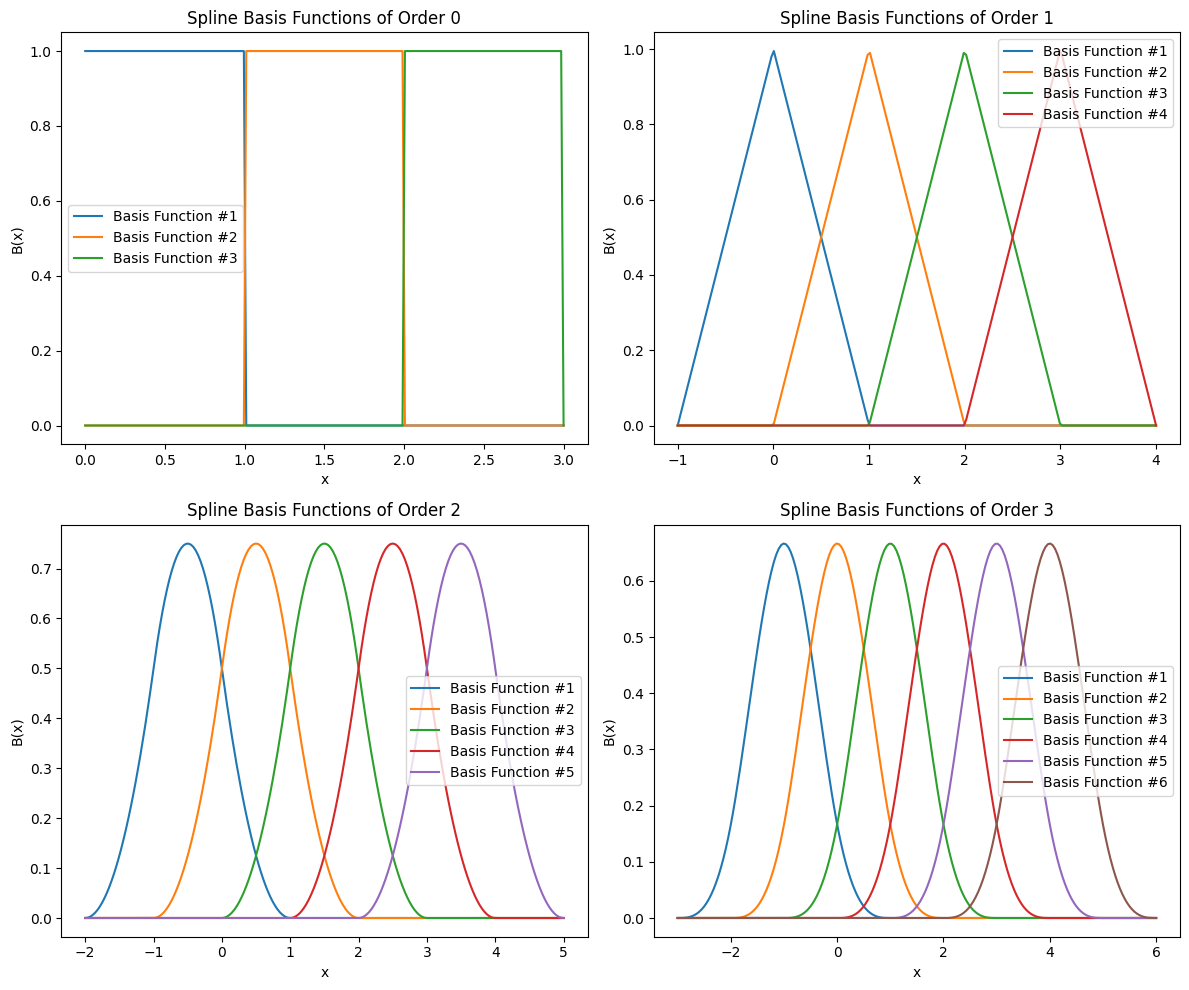

In [6]:
k_vals = [0,1,2,3]
num_x = 200

fig, axes = plt.subplots(2,2, figsize=(12,10))

for idx, k in enumerate(k_vals):
    grid = get_grid(1, T, G, k)

    # Get xs
    x = np.linspace(grid[0, 0], grid[0, -1], num_x)
    x_reshaped = x.reshape((num_x, 1))

    # Call the function
    basis_splines = spline(torch.from_numpy(x_reshaped), torch.from_numpy(grid), k, extend=False)

    # Reshape
    funcs = basis_splines.reshape((x_reshaped.shape[0], basis_splines.shape[-2])).detach().cpu()

    # Determine the subplot position
    ax = axes[idx // 2, idx % 2]
    
    for i in range(funcs.shape[1]):
        ax.plot(x, funcs[:, i], label=f'Basis Function #{i + 1}')

    # Adding labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('B(x)')
    ax.set_title(f'Spline Basis Functions of Order {k}')
    ax.legend()

plt.tight_layout()
plt.show()






In [7]:
from kan_layer import kan_layer

n_in = 2
n_out = 3

layer = kan_layer(n_in, n_out,6,3, device='cuda')
inp = torch.rand(1,2, device='cuda')
layer(inp)

(tensor([[0.3245, 0.3203, 0.3196]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.0008, 0.0011],
         [0.0010, 0.0012],
         [0.0046, 0.0016]], device='cuda:0', grad_fn=<DivBackward0>))

In [8]:
from KAN import KAN

model = KAN([28 * 28, 64, 10])
inp = torch.rand(1,28*28, device='cuda')
model(inp)

tensor([[0.1938, 0.1938, 0.1931, 0.1937, 0.1946, 0.1939, 0.1928, 0.1928, 0.1933,
         0.1932]], device='cuda:0', grad_fn=<MulBackward0>)

In [2]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
#Load mnist data
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 2792829.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 360248.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2884764.61it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6975660.48it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
#model
model = KAN([28 * 28, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [11]:
criterion = nn.CrossEntropyLoss()
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )

100%|██████████| 938/938 [01:05<00:00, 14.24it/s, accuracy=0.438, loss=1.81, lr=0.001] 


Epoch 1, Val Loss: 1.7943811371068286, Val Accuracy: 0.3532046178343949


100%|██████████| 938/938 [01:06<00:00, 14.19it/s, accuracy=0.562, loss=1.41, lr=0.0008]


Epoch 2, Val Loss: 1.3431198050262063, Val Accuracy: 0.565187101910828


100%|██████████| 938/938 [01:07<00:00, 13.82it/s, accuracy=0.719, loss=1.08, lr=0.00064] 


Epoch 3, Val Loss: 1.0097831555992176, Val Accuracy: 0.6914808917197452


100%|██████████| 938/938 [01:04<00:00, 14.43it/s, accuracy=0.781, loss=0.798, lr=0.000512]


Epoch 4, Val Loss: 0.8178290745634942, Val Accuracy: 0.7576632165605095


100%|██████████| 938/938 [01:03<00:00, 14.84it/s, accuracy=0.75, loss=0.581, lr=0.00041] 


Epoch 5, Val Loss: 0.7033748900055126, Val Accuracy: 0.7937898089171974


100%|██████████| 938/938 [01:03<00:00, 14.69it/s, accuracy=0.906, loss=0.58, lr=0.000328] 


Epoch 6, Val Loss: 0.6301397977361254, Val Accuracy: 0.8194665605095541


100%|██████████| 938/938 [01:02<00:00, 15.05it/s, accuracy=0.906, loss=0.472, lr=0.000262]


Epoch 7, Val Loss: 0.5812606059821548, Val Accuracy: 0.8335987261146497


100%|██████████| 938/938 [01:02<00:00, 15.09it/s, accuracy=0.875, loss=0.475, lr=0.00021]


Epoch 8, Val Loss: 0.5476996288367897, Val Accuracy: 0.8431528662420382


100%|██████████| 938/938 [01:01<00:00, 15.14it/s, accuracy=0.875, loss=0.445, lr=0.000168]


Epoch 9, Val Loss: 0.5240072329902346, Val Accuracy: 0.8495222929936306


100%|██████████| 938/938 [01:01<00:00, 15.16it/s, accuracy=0.906, loss=0.443, lr=0.000134]


Epoch 10, Val Loss: 0.5066365470552141, Val Accuracy: 0.8541003184713376


In [20]:
for img, lbl in valloader:
    img = img.view(-1, 28 * 28).to(device)

    print(torch.argmax(model(img), dim=1))
    print(lbl)
    break

tensor([7, 2, 1, 0, 4, 1, 9, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 3, 1, 1, 7, 9, 2, 3, 5, 1, 2,
        9, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 4, 2], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [14]:
torch.save(model, 'mnist_test')